In [8]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)

import extraction_squares

if operating_system == 'curnagl':
    name_of_variable= pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS/variable_list_80_mean.csv')
    path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS'
else:
    name_of_variable= pd.read_csv('data/variable_list_80_mean.csv')
    path_data = 'data'

storm_dates = pd.read_csv('pre_processing/tracks/storm_dates.csv')
path_tracks_1h = 'pre_processing/tracks/ALL_TRACKS/tracks_1h'
#path_tracks_1h_non_EU = 'pre_processing/tracks/ALL_TRACKS/tracks_1h_non_EU'
dataset = 'datasets_1h'
#dataset_non_EU = 'datasets_1h_non_EU'

In [3]:
X_train, X_test, X_validation, y_train, y_test, y_validation, X_all_3d, y_all_3d = extraction_squares.X_y_datasets_EU(name_of_variable, storm_dates, path_data, path_tracks_1h, dataset, False)

Shape of the X 3D ndarray: (96, 472, 316)
Shape of the y 3D ndarray: (96, 472, 4)
Storm Training: [ 0  2  3  4  5  6  7 11 12 13 14 16 17 18 19 20 21 22 23 24 25 27 28 29
 31 34 35 36 37 38 39 40 42 43 44 46 47 48 50 53 54 56 57 58 61 64 66 69
 70 71 73 75 76 77 78 79 81 82 83 85 86 87 88 90 92 93 94 95]
Storm Test: [ 1  9 10 15 26 33 52 59 60 62 63 68 74 84]
Storm Valid: [ 8 30 32 41 45 49 51 55 65 67 72 80 89 91]
Order of the stats : 'max', 'min', 'mean', 'std'


In [14]:
# reshape the X_training into a 2D array

X_all_2d = X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2])
# same for y_all_3d
y_all_2d = y_train.reshape(y_train.shape[0]*y_train.shape[1],y_train.shape[2])

# drop all the rows with nan values

X_all_2d = pd.DataFrame(X_all_2d)
X_all_2d = X_all_2d.dropna()
y_all_2d = pd.DataFrame(y_all_2d)
y_all_2d = y_all_2d.dropna()

# rename the columns by the name of the variables by adding also the stat of the variable (max, min, mean, std)

stats = ['max', 'min', 'mean', 'std']
var_stat = []
var_stat_all = []

for var in name_of_variable['variables']:
    for stat in stats:
        var_stat = f'{var}_{stat}'
        var_stat_all.append(var_stat)

# drop instantaneous variables

var_stat_all = [var for var in var_stat_all if 'inst' not in var]
instantaneous = ['instantaneous_10m_wind_gust_max', 'instantaneous_10m_wind_gust_min', 'instantaneous_10m_wind_gust_mean', 'instantaneous_10m_wind_gust_std']

X_all_2d.columns = var_stat_all
y_all_2d.columns = instantaneous

y_mean = y_all_2d.drop(columns=['instantaneous_10m_wind_gust_max', 'instantaneous_10m_wind_gust_min', 'instantaneous_10m_wind_gust_std'])
y_max = y_all_2d.drop(columns=['instantaneous_10m_wind_gust_min', 'instantaneous_10m_wind_gust_mean', 'instantaneous_10m_wind_gust_std'])

In [15]:
# using RandomForests to find the most important features

# Create a random forest Regressor
rf_max = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
rf_mean = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)

# Train the model on training data
rf_max.fit(X_all_2d, y_max)
rf_mean.fit(X_all_2d, y_mean)

/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_jobs=-1, random_state=42)

Feature ranking:
1. feature 10m_u_component_of_wind_max (0.7040718970821443)
2. feature mean_surface_latent_heat_flux_std (0.11527794029947964)
3. feature 10m_v_component_of_wind_max (0.046236161037587535)
4. feature 10m_v_component_of_wind_std (0.019656587725180634)
5. feature geopotential_1000_std (0.014999062121003449)
6. feature 10m_v_component_of_wind_min (0.007543783963010802)
7. feature vertical_velocity_850_std (0.007011692846567229)
8. feature 10m_u_component_of_wind_min (0.0032753456396593596)
9. feature vertical_velocity_800_std (0.002977168522398911)
10. feature vertical_velocity_900_std (0.0028551786637836733)
11. feature mean_surface_latent_heat_flux_min (0.002605253919490918)
12. feature 10m_u_component_of_wind_std (0.0023602307390383982)
13. feature mean_sea_level_pressure_std (0.001739479321896216)
14. feature mean_sea_level_pressure_min (0.001262707998144695)
15. feature vertical_velocity_850_max (0.0012128143350534643)
16. feature mean_vertically_integrated_moisture_

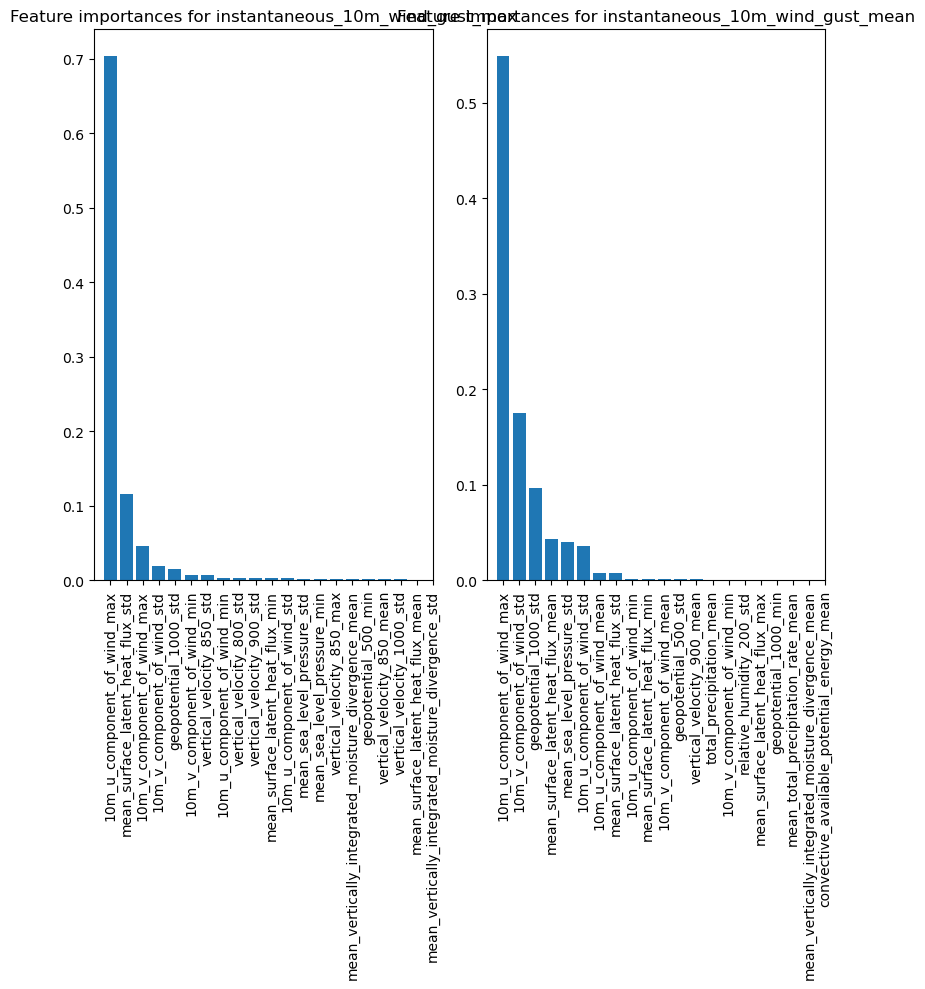

In [26]:
# Get the feature importance
importances_max = rf_max.feature_importances_
importances_mean = rf_mean.feature_importances_

# Sort the features
indices_max = np.argsort(importances_max)[::-1]
indices_mean = np.argsort(importances_mean)[::-1]
var_stat_all_sorted_max = [var_stat_all[i] for i in indices_max]
var_stat_all_sorted_mean = [var_stat_all[i] for i in indices_mean]


# Print the feature ranking
print("Feature ranking:")
for f in range(X_all_2d.shape[1]):
    print(f"{f+1}. feature {var_stat_all_sorted_max[f]} ({importances_max[indices_max[f]]})")

# Plot the feature importances of the forest
subset = 20

# with 2 plots, 1 for the max and 1 for the mean

fig, axes = plt.subplots(1, 2, figsize=(8, 10))  # 2 rows, 1 column

axes[0].set_title("Feature importances for instantaneous_10m_wind_gust_max")
axes[0].bar(range(X_all_2d.shape[1]), importances_max[indices_max], align="center")
axes[0].set_xticks(range(X_all_2d.shape[1]), var_stat_all_sorted_max, rotation=90)
axes[0].set_xlim([-1, subset])

axes[1].set_title("Feature importances for instantaneous_10m_wind_gust_mean")
axes[1].bar(range(X_all_2d.shape[1]), importances_mean[indices_mean], align="center")
axes[1].set_xticks(range(X_all_2d.shape[1]), var_stat_all_sorted_mean, rotation=90)
axes[1].set_xlim([-1, subset])

plt.tight_layout()
plt.show()

    